# Phishing Website Detection based on Supervised Machine Learning with Wrapper Features Selection

Phishing web stranice su replika nekih drugih, legitimnih web stranica. Napadač ih koristi kako bi naveo žrtve da mu pošalju osjetljive podatke poput e-maila, lozinki, broja kartica i sl. Zbog identičnog izgleda kao i legitimna stranica, korisnik nije svjestan da se nalazi na zlonamjernoj stranici te vrlo često ostavlja osjetljive podatke. 

S porastom korištenja internet usluga, raste i broj phishing stranica.
Takve stranice ne oštećuju samo korisnike, već i pružatelje usluga jer se stvara nepovjerenje prema pružatelju usluga iako sam pružatelj nije uopće sudjelovao u napadu.

S obzirom da korisnici teško uočavaju razliku između stvarne i phishing stranice, automatizirana detekcija i uklanjanje takvih stranica bi učinila internetski prostor puno sigurnijim. Dodatno bi korisnici imali veće povjerenje prema pružateljima usluga te bi pružatelji usluga uživali veći promet na vlastitim stranicama.

Proces izrade modela za detekciju phishing stranica je sljedeći:

1. Učitavanje skupa podataka
2. Odabir značajki primjenom postupka omotača
3. Učenje i vrednovanje modela korištenjem dobivenih značajki
4. Prikaz rezultata

In [97]:
# importing required functions and libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings

from scipy.io.arff import loadarff
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SequentialFeatureSelector, mutual_info_classif
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from IPython.display import display_html 

warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = [4, 5]


# Učitavanje skupa podataka

Podaci se učitavaju iz *Train Dataset.arff* datoteke u prikladni Pandas DataFrame. 
Podaci su opisani i vizualizirani u Python bilježnici *dataset.ipynb*.

Podaci učitani u Pandas DataFrame razdvajaju se u varijablu X koja sadrži sve značajke pojedinih podataka, te u varijablu Y u kojoj se nalaze ciljne oznake podataka.

Blok sa kodom dodatno ispisuje nazive svih značajki te ukupan broj značajki u skupu podataka. Pojedine značajke su također opisane u Python bilježnici *dataset.ipynb*. 


In [98]:
raw_data, metadata = loadarff("data/Training Dataset.arff",)
data = pd.DataFrame(raw_data)

#convert values to integers instead of strings
for col in data.columns:
    data[col] = data[col].astype(int)
    col = col.lower()

# data
X = data.loc[:, data.columns != "Result"]
# labels
Y = data.loc[:, data.columns == "Result"]


print("Features:")
print(", ".join(X.columns))
print()
print("Number of features: " + str(len(X.columns)))

Features:
having_IP_Address, URL_Length, Shortining_Service, having_At_Symbol, double_slash_redirecting, Prefix_Suffix, having_Sub_Domain, SSLfinal_State, Domain_registeration_length, Favicon, port, HTTPS_token, Request_URL, URL_of_Anchor, Links_in_tags, SFH, Submitting_to_email, Abnormal_URL, Redirect, on_mouseover, RightClick, popUpWidnow, Iframe, age_of_domain, DNSRecord, web_traffic, Page_Rank, Google_Index, Links_pointing_to_page, Statistical_report

Number of features: 30


# Odabir značajki

Važan dio pri izradi modela za detekciju phishing web stranica je odabir značajki koje će se dovoditi na ulaz modela za detekciju. Odabir značajki se vrši primjenom postupka omotača.
 
Podskup značajki dobiven metodom omotača dovodi se na ulaz modela te se preciznost tih modela uspoređuje se sa modelima koji na ulazu koriste značajke dobivene analizom glavnih komponenti te modelima koji na ulazu koriste značajke koje imaju najveću informacijsku dobit.

### Odabir značajki postupcima omotača

Postupci omotača su postupci čiji je cilj odabrati najmanji podskup značajki koji daje najbolje rezultate za klasifikaciju.
Za svaki odabrani podskup se vrednuje točnost modela kada se na ulaz modela dovode podskupovi značajki i među vrednovanim podskupovima odabire se onaj podskup za koji model daje najveću točnost.

Vrednovanje modela se odvija pomoću 5-struke unakrsne provjere gdje se skup podataka dijeli na 5 jednakih djelova gdje je u svakoj iteraciji jedan od pet dijelova skup za testiranje.

U konkretnom slučaju podskupovi se evaluiraju mjerenjem točnosti 3-NN algoritma na testnom skupu podataka te se kao kriterij uzima prosječna točnost tog modela.

Metode omotača se razlikuju po strategiji odabira podskupova značajki. Neke od metoda odabira su:
- Unaprijedna selekcija - Prvo se evaluiraju podskupovi sa jednom značajkom, zatim sa dvije, itd.
- Eliminacija unatrag - Prvo se evaluiraja cijeli skup, zatim se vrednuju skupovi sa jednom značajkom manje itd.
- Dvosmjerna eliminacija - Postupno se dodaju nove značajke u podskup koji se vrednuje i istovremeno se uklanjanju statistički nevažne značajke


In [99]:
feature_selector = SequentialFeatureSelector(
    estimator=KNeighborsClassifier(n_neighbors=3),
    n_features_to_select="auto",
    tol=0.001,
    direction="backward",
    scoring="accuracy",
    n_jobs=-1
)

feature_selector.fit(X, Y)

selected_features = feature_selector.get_feature_names_out(X.columns)

X_wrapper_features = X[selected_features]

### Odabir značajki prijenom analize glavnih komponenti

Analiza glavnih komponenti je statistička metoda za reduciranje dimenzionalnosti podataka. Redukcija dimenzionalnosti se vrši tako da se višedimenzionalni podaci preslikavaju u nižedimenzionalni prostor pri čemu se nastoji sačuvati varijacija u podacima. 

Podaci se reduciraju u 7-dimenzionalan prostor. 

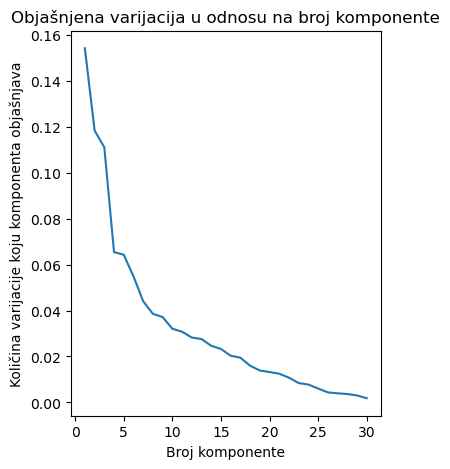

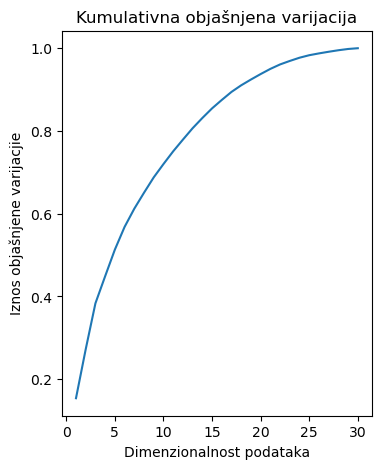

In [100]:
pca = PCA(n_components=30) 
X_pca = pca.fit_transform(X, Y)

cumulative_sum_evr = []
for i in range(1, 31):
    sum_evr = 0.0
    for j in range(0, i):
        sum_evr += pca.explained_variance_ratio_[j]
        
    cumulative_sum_evr.append(sum_evr)

plt.title("Objašnjena varijacija u odnosu na broj komponente")
plt.plot(range(1, 31), pca.explained_variance_ratio_)
plt.xlabel("Broj komponente")
plt.ylabel("Količina varijacije koju komponenta objašnjava")
plt.show()

plt.title("Kumulativna objašnjena varijacija")
plt.plot(range(1, 31), cumulative_sum_evr)
plt.xlabel("Dimenzionalnost podataka")
plt.ylabel("Iznos objašnjene varijacjie")
plt.show()


Na grafu se može vidjeti da redukcija u 7-dimenzionalan prostor zadržava otprilike 75% varijacije u podacima te se stoga provodi redukcija dimenzionalnosti 30-dimenzionalnih podataka u 7-dimenzionalne podatke.

In [101]:

N_COMPONENTS = 7
X_pca = PCA(n_components=N_COMPONENTS).fit_transform(X, Y)

### Odabir značajki pomoću informacijske dobiti značajki

Informacijska dobit je mjera koja opisuje očekivano smanjenje entropije uslijed dijeljenja skupa podataka po vrijednostima neke značajke. Što je informacijska dobit veća, to značajka bolje opisuje skup podataka.

Za svaku značajku se računa informacijska dobit. Iterativno se uzima k od n značajki te se mjeri preciznost svih modela. Za svaki model se uzima onoliko značajki za koliko model ima najveću preciznost.

In [102]:
def get_ig_features(X, Y , n_components):
    ig_features = sorted(dict(zip(X.columns, mutual_info_classif(X, Y, discrete_features=True))), reverse=True)[:n_components]
    X_ig = X[ig_features]
    return X_ig


# Modeli nadziranog strojnog učenja

Modeli nadziranog strojnog učenja koji će se trenirati za klasifikaciju stranica su:

- k-NN algoritam
- Naivni Bayesov klasifikator
- SVM
- Stablo odluke
- Random forest stabla odluke
- Višeslojni perceptron
- Mreže radijalnih baznih funkcija 

U ovom djelu se definira metoda za evaluaciju modela strojnog učenja. 

Za evaluaciju modela koristi se 5-struka unakrsna provjera. 
5-struka unakrsna provjera radi na principu da skup podataka podijeli na 5 jednakih dijelova. 
Od tih pet dijelova, jedan od njih predstavlja testni skup dok ostali predstavljaju skup za treniranje. 
Model se trenira sa skupom za treniranje te se na kraju vrednuje na skupu za treniranje i na skupu za testiranje. 
Taj postupak se ponavlja 5 puta pri čemu je svaki put drugi dio podataka testni skup podataka. 
Rezultat ovakve validacije je 5 različitih mjerenja preciznosti čiji se prosjek uzima kao konačna preciznost modela.

In [103]:
def evaluate_ml_model(model, X, Y):
    NUM_OF_FOLDS = 5
    scoring = ["accuracy", "precision", "recall", "f1"]
    results = cross_validate(estimator=model,
                                X = X,
                                y = Y,
                                cv = NUM_OF_FOLDS,
                                scoring = scoring,
                                return_train_score=True, n_jobs=-1)
    return results

In [104]:
results_without_fs_train = pd.DataFrame(columns=["accuracy", "precision", "recall", "f1"], 
    index=["Naivni Bayesov klasifikator", "k-NN", "SVM", "Stablo odluke", "Random Forest stabla odluke", "Višeslojni perceptron"])
results_wrapper_train = pd.DataFrame(columns=["accuracy", "precision", "recall", "f1"], 
    index=["Naivni Bayesov klasifikator", "k-NN", "SVM", "Stablo odluke", "Random Forest stabla odluke", "Višeslojni perceptron"])
results_pca_train = pd.DataFrame(columns=["accuracy", "precision", "recall", "f1"], 
    index=["Naivni Bayesov klasifikator", "k-NN", "SVM", "Stablo odluke", "Random Forest stabla odluke", "Višeslojni perceptron"])
results_ig_train = pd.DataFrame(columns=["accuracy", "precision", "recall", "f1"], 
    index=["Naivni Bayesov klasifikator", "k-NN", "SVM", "Stablo odluke", "Random Forest stabla odluke", "Višeslojni perceptron"])

results_without_fs_test = pd.DataFrame(columns=["accuracy", "precision", "recall", "f1"], 
    index=["Naivni Bayesov klasifikator", "k-NN", "SVM", "Stablo odluke", "Random Forest stabla odluke", "Višeslojni perceptron"])
results_wrapper_test = pd.DataFrame(columns=["accuracy", "precision", "recall", "f1"], 
    index=["Naivni Bayesov klasifikator", "k-NN", "SVM", "Stablo odluke", "Random Forest stabla odluke", "Višeslojni perceptron"])
results_pca_test = pd.DataFrame(columns=["accuracy", "precision", "recall", "f1"], 
    index=["Naivni Bayesov klasifikator", "k-NN", "SVM", "Stablo odluke", "Random Forest stabla odluke", "Višeslojni perceptron"])
results_ig_test = pd.DataFrame(columns=["accuracy", "precision", "recall", "f1"], 
    index=["Naivni Bayesov klasifikator", "k-NN", "SVM", "Stablo odluke", "Random Forest stabla odluke", "Višeslojni perceptron"])

## Evaluacija naivnog Bayesovog klasifikatora

Naivan bayesov klasifikator se vodi pretpostavkom da su sve značajke u skupu podataka međusobno nezavisne.

Klasifikacija se vrši preko izglednosti razreda podataka. Odnosno računa se $p(x | z=y)$ pri čemu je y oznaka nekog razreda. 
Zbog pretpostavke o nezavisnosti podataka, izraz $p(x | z=y)$ može se raspisati kao 
$p(x | z=y) = p(x_1 | z=y) p(x_2 | z=y) ... p(x_n | z=y)$ pri čemu je $x_i$ neka značajka podatka.
Podatak se svrstava u razred za koji je $p(x | z=y_i)$ najveći.

Pojedini faktor $p(x_i | z=y)$ procjenjuje se kao omjer broja podataka sa nekom konkretnom vrijednošću $x_i$ i $z$ i broja podataka sa vrijednošću $z$


Hiperparametar naivnog Bayesovog klasifikatora koji se ugađa je $\alpha$ koja predstavlja Laplaceov faktor zaglađivanja koji se koristi u svrhu spriječavanja prenaučenosti modela. Navedeni faktor se primjenjuje kao dodatak prethodno navedenom faktoru vjerojatnosti.
Raspon parametra $\alpha$ koji se evaluira je $[0, 10]$ pri čemu je $\alpha \in \mathbb{N}$

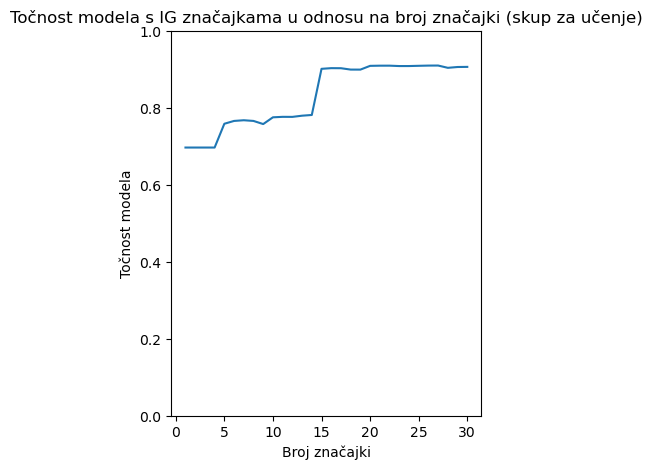

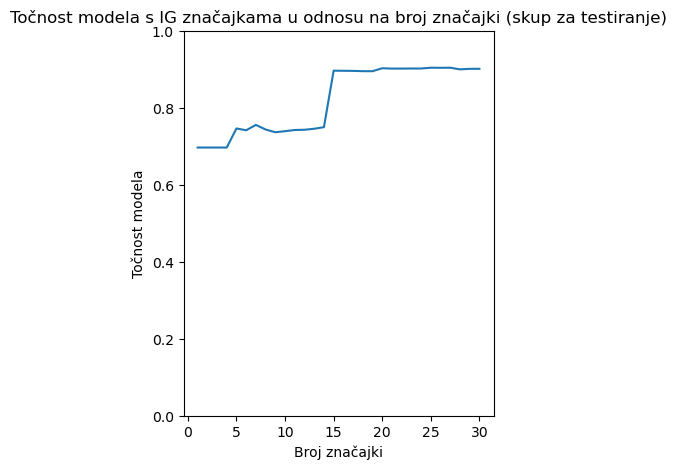

In [108]:
accuracies = np.zeros((2, 30))
precisions = np.zeros((2, 30))
recalls = np.zeros((2, 30))
f1_scores = np.zeros((2, 30))

parameters = {"CategoricalNB__alpha" : range(1, 10 + 1)}
clf = GridSearchCV(estimator=Pipeline([('Normalizing',MinMaxScaler()),('CategoricalNB',CategoricalNB())]), param_grid=parameters, n_jobs=-1)
clf.fit(X, Y)
nbc_wf = clf.best_estimator_

eval_results = evaluate_ml_model(nbc_wf, X, Y)
results_without_fs_train.loc["Naivni Bayesov klasifikator", "accuracy"] = eval_results["train_accuracy"].mean()
results_without_fs_test.loc["Naivni Bayesov klasifikator", "accuracy"] = eval_results["test_accuracy"].mean()
results_without_fs_train.loc["Naivni Bayesov klasifikator", "precision"] = eval_results["train_precision"].mean()
results_without_fs_test.loc["Naivni Bayesov klasifikator", "precision"] = eval_results["test_precision"].mean()
results_without_fs_train.loc["Naivni Bayesov klasifikator", "recall"] = eval_results["train_recall"].mean()
results_without_fs_test.loc["Naivni Bayesov klasifikator", "recall"] = eval_results["test_recall"].mean()
results_without_fs_train.loc["Naivni Bayesov klasifikator", "f1"] = eval_results["train_f1"].mean()
results_without_fs_test.loc["Naivni Bayesov klasifikator", "f1"] = eval_results["test_f1"].mean()

clf.fit(X_wrapper_features, Y)
nbc_wrapper_features = clf.best_estimator_
eval_results = evaluate_ml_model(nbc_wrapper_features, X_wrapper_features, Y)

results_wrapper_train.loc["Naivni Bayesov klasifikator", "accuracy"] = eval_results["train_accuracy"].mean()
results_wrapper_test.loc["Naivni Bayesov klasifikator", "accuracy"] = eval_results["test_accuracy"].mean()
results_wrapper_train.loc["Naivni Bayesov klasifikator", "precision"] = eval_results["train_precision"].mean()
results_wrapper_test.loc["Naivni Bayesov klasifikator", "precision"] = eval_results["test_precision"].mean()
results_wrapper_train.loc["Naivni Bayesov klasifikator", "recall"] = eval_results["train_recall"].mean()
results_wrapper_test.loc["Naivni Bayesov klasifikator", "recall"] = eval_results["test_recall"].mean()
results_wrapper_train.loc["Naivni Bayesov klasifikator", "f1"] = eval_results["train_f1"].mean()
results_wrapper_test.loc["Naivni Bayesov klasifikator", "f1"] = eval_results["test_f1"].mean()


parameters = {"GaussianNB__var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6]}
clf = GridSearchCV(estimator=Pipeline([('Normalizing',MinMaxScaler()),('GaussianNB',GaussianNB())]), param_grid=parameters, n_jobs=-1)
clf.fit(X_pca, Y)
nbc_pca = clf.best_estimator_

eval_results = evaluate_ml_model(nbc_pca, X_pca, Y)

results_pca_train.loc["Naivni Bayesov klasifikator", "accuracy"] = eval_results["train_accuracy"].mean()
results_pca_test.loc["Naivni Bayesov klasifikator", "accuracy"] = eval_results["test_accuracy"].mean()
results_pca_train.loc["Naivni Bayesov klasifikator", "precision"] = eval_results["train_precision"].mean()
results_pca_test.loc["Naivni Bayesov klasifikator", "precision"] = eval_results["test_precision"].mean()
results_pca_train.loc["Naivni Bayesov klasifikator", "recall"] = eval_results["train_recall"].mean()
results_pca_test.loc["Naivni Bayesov klasifikator", "recall"] = eval_results["test_recall"].mean()
results_pca_train.loc["Naivni Bayesov klasifikator", "f1"] = eval_results["train_f1"].mean()
results_pca_test.loc["Naivni Bayesov klasifikator", "f1"] = eval_results["test_f1"].mean()


for n_components in range(1, 30 + 1):
    X_ig = get_ig_features(X, Y, n_components)
    parameters = {"CategoricalNB__alpha" : range(1, 10 + 1)}
    clf = GridSearchCV(estimator=Pipeline([('Normalizing',MinMaxScaler()),('CategoricalNB',CategoricalNB())]), param_grid=parameters, n_jobs=-1)
    clf.fit(X_ig, Y)
    nbc_ig = clf.best_estimator_

    eval_results = evaluate_ml_model(nbc_ig, X_ig, Y)
    accuracies[0, n_components-1] = eval_results["train_accuracy"].mean()
    precisions[0, n_components-1] = eval_results["train_precision"].mean()
    recalls[0, n_components-1] = eval_results["train_recall"].mean()
    f1_scores[0, n_components-1] = eval_results["train_f1"].mean()

    accuracies[1, n_components-1] = eval_results["test_accuracy"].mean()
    precisions[1, n_components-1] = eval_results["test_precision"].mean()
    recalls[1, n_components-1] = eval_results["test_recall"].mean()
    f1_scores[1, n_components-1] = eval_results["test_f1"].mean()

results_ig_train.loc["Naivni Bayesov klasifikator", "accuracy"] = np.max(accuracies, axis=1)[0]
results_ig_test.loc["Naivni Bayesov klasifikator", "accuracy"] = np.max(accuracies, axis=1)[1]
results_ig_train.loc["Naivni Bayesov klasifikator", "precision"] = np.max(precisions, axis=1)[0]
results_ig_test.loc["Naivni Bayesov klasifikator", "precision"] = np.max(precisions, axis=1)[1]
results_ig_train.loc["Naivni Bayesov klasifikator", "recall"] = np.max(recalls, axis=1)[0]
results_ig_test.loc["Naivni Bayesov klasifikator", "recall"] = np.max(recalls, axis=1)[1]
results_ig_train.loc["Naivni Bayesov klasifikator", "f1"] = np.max(f1_scores, axis=1)[0]
results_ig_test.loc["Naivni Bayesov klasifikator", "f1"] = np.max(f1_scores, axis=1)[1]

plt.title("Točnost modela s IG značajkama u odnosu na broj značajki (skup za učenje)")
plt.plot(range(1,30 + 1), accuracies[0,:], scaley=[0, 1])
plt.xlabel("Broj značajki")
plt.ylabel("Točnost modela")
plt.ylim(top=1, bottom=0)
plt.show()

plt.title("Točnost modela s IG značajkama u odnosu na broj značajki (skup za testiranje)")
plt.plot(range(1,30 + 1), accuracies[1,:], scaley=[0, 1])
plt.xlabel("Broj značajki")
plt.ylabel("Točnost modela")
plt.ylim(top=1, bottom=0)
plt.show()

## Evaluacija k-NN algoritma

Algoritam $k$ najbližih susjeda klasificira podatke na temelju usporedbe udaljenosti podatka koji se klasificira od drugih podataka. 

Podaci iz skupa za učenje služe kao referentni podaci, odnosno podaci s kojima će se uspoređivati udaljenosti novodovedenih podataka prilikom klasifikacije. 
Kada se na ulaz dovede novi podatak, mjeri se njegova udaljenost u odnosu na podatke iz skupa za učenje. 
Zatim se odabire $k$ najbližih podataka te se dovedeni podatak svrstava u razred kojem pripada većina najbližih podataka. 
Pretpostavka kojom se ovaj model vodi je da će podaci iz istog razreda biti međusobno grupirani u višedimenzionalnom prostoru, kao i pretpostavkom da će podaci iz različitih razreda biti udaljeni.

Hiperparametar koji se vrednuje kod modela $k$ najbližih susjeda je broj "susjeda" koji se uzimaju u obzir prilikom klasifikacije. Za potrebe projekta, biti će ispitana preciznost klasifikatora za koji je vrijednost hiperparametra $k$ u rasponu od $[0, 10]$

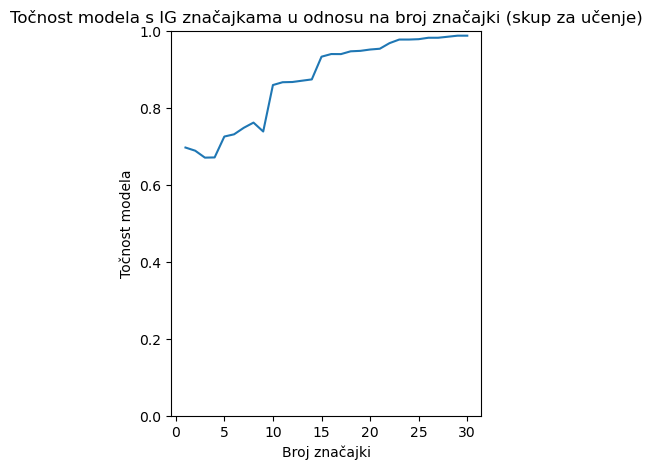

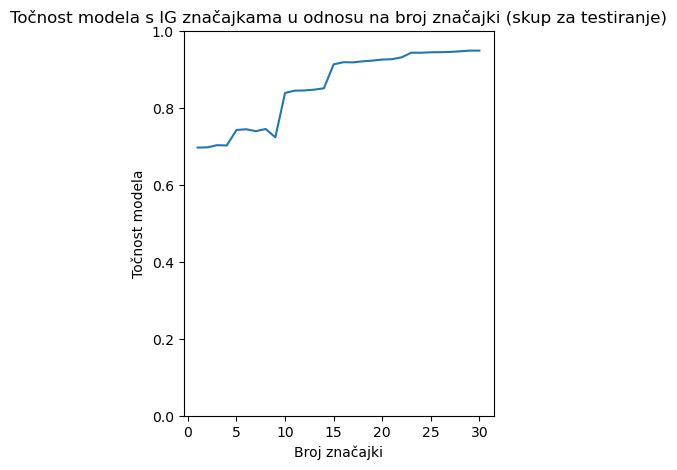

In [110]:
accuracies = np.zeros((2, 30))
precisions = np.zeros((2, 30))
recalls = np.zeros((2, 30))
f1_scores = np.zeros((2, 30))

parameters = {"n_neighbors" : range(1, 10 + 1)}
clf = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=parameters, n_jobs=-1)
clf.fit(X, Y)
knn_wf = clf.best_estimator_

eval_results = evaluate_ml_model(knn_wf, X, Y)
results_without_fs_train.loc["k-NN", "accuracy"] = eval_results["train_accuracy"].mean()
results_without_fs_test.loc["k-NN", "accuracy"] = eval_results["test_accuracy"].mean()
results_without_fs_train.loc["k-NN", "precision"] = eval_results["train_precision"].mean()
results_without_fs_test.loc["k-NN", "precision"] = eval_results["test_precision"].mean()
results_without_fs_train.loc["k-NN", "recall"] = eval_results["train_recall"].mean()
results_without_fs_test.loc["k-NN", "recall"] = eval_results["test_recall"].mean()
results_without_fs_train.loc["k-NN", "f1"] = eval_results["train_f1"].mean()
results_without_fs_test.loc["k-NN", "f1"] = eval_results["test_f1"].mean()

clf.fit(X_wrapper_features, Y)
knn_wrapper_features = clf.best_estimator_
eval_results = evaluate_ml_model(knn_wrapper_features, X_wrapper_features, Y)

results_wrapper_train.loc["k-NN", "accuracy"] = eval_results["train_accuracy"].mean()
results_wrapper_test.loc["k-NN", "accuracy"] = eval_results["test_accuracy"].mean()
results_wrapper_train.loc["k-NN", "precision"] = eval_results["train_precision"].mean()
results_wrapper_test.loc["k-NN", "precision"] = eval_results["test_precision"].mean()
results_wrapper_train.loc["k-NN", "recall"] = eval_results["train_recall"].mean()
results_wrapper_test.loc["k-NN", "recall"] = eval_results["test_recall"].mean()
results_wrapper_train.loc["k-NN", "f1"] = eval_results["train_f1"].mean()
results_wrapper_test.loc["k-NN", "f1"] = eval_results["test_f1"].mean()


clf.fit(X_pca, Y)
knn_pca = clf.best_estimator_
eval_results = evaluate_ml_model(knn_pca, X_pca, Y)

results_pca_train.loc["k-NN", "accuracy"] = eval_results["train_accuracy"].mean()
results_pca_test.loc["k-NN", "accuracy"] = eval_results["test_accuracy"].mean()
results_pca_train.loc["k-NN", "precision"] = eval_results["train_precision"].mean()
results_pca_test.loc["k-NN", "precision"] = eval_results["test_precision"].mean()
results_pca_train.loc["k-NN", "recall"] = eval_results["train_recall"].mean()
results_pca_test.loc["k-NN", "recall"] = eval_results["test_recall"].mean()
results_pca_train.loc["k-NN", "f1"] = eval_results["train_f1"].mean()
results_pca_test.loc["k-NN", "f1"] = eval_results["test_f1"].mean()

for n_components in range(1, 30 + 1):
    X_ig = get_ig_features(X, Y, n_components)
    clf.fit(X_ig, Y)
    knn_ig = clf.best_estimator_

    eval_results = evaluate_ml_model(knn_ig, X_ig, Y)
    accuracies[0, n_components-1] = eval_results["train_accuracy"].mean()
    precisions[0, n_components-1] = eval_results["train_precision"].mean()
    recalls[0, n_components-1] = eval_results["train_recall"].mean()
    f1_scores[0, n_components-1] = eval_results["train_f1"].mean()

    accuracies[1, n_components-1] = eval_results["test_accuracy"].mean()
    precisions[1, n_components-1] = eval_results["test_precision"].mean()
    recalls[1, n_components-1] = eval_results["test_recall"].mean()
    f1_scores[1, n_components-1] = eval_results["test_f1"].mean()

results_ig_train.loc["k-NN", "accuracy"] = np.max(accuracies, axis=1)[0]
results_ig_test.loc["k-NN", "accuracy"] = np.max(accuracies, axis=1)[1]
results_ig_train.loc["k-NN", "precision"] = np.max(precisions, axis=1)[0]
results_ig_test.loc["k-NN", "precision"] = np.max(precisions, axis=1)[1]
results_ig_train.loc["k-NN", "recall"] = np.max(recalls, axis=1)[0]
results_ig_test.loc["k-NN", "recall"] = np.max(recalls, axis=1)[1]
results_ig_train.loc["k-NN", "f1"] = np.max(f1_scores, axis=1)[0]
results_ig_test.loc["k-NN", "f1"] = np.max(f1_scores, axis=1)[1]

plt.title("Točnost modela s IG značajkama u odnosu na broj značajki (skup za učenje)")
plt.plot(range(1,30 + 1), accuracies[0,:], scaley=[0, 1])
plt.xlabel("Broj značajki")
plt.ylabel("Točnost modela")
plt.ylim(top=1, bottom=0)
plt.show()

plt.title("Točnost modela s IG značajkama u odnosu na broj značajki (skup za testiranje)")
plt.plot(range(1,30 + 1), accuracies[1,:], scaley=[0, 1])
plt.xlabel("Broj značajki")
plt.ylabel("Točnost modela")
plt.ylim(top=1, bottom=0)
plt.show()

## Evaluacija SVM-a

SVM je model koji modelira decizijsku granicu između razreda nastojeći pri tome maksimizirati udaljenost decizijske granice između pojedinih razreda.

Hiperparametri SVM-a koji se ugađaju su $\gamma$ i $C$ pri čemu parametar $C$ predstavlja regularizacijski faktor, dok parametar $\gamma$ predstavlja koefcijent jezgre. 

U evaluaciji modela SVM model koristi jezgru radijalnih baznih funkcija.

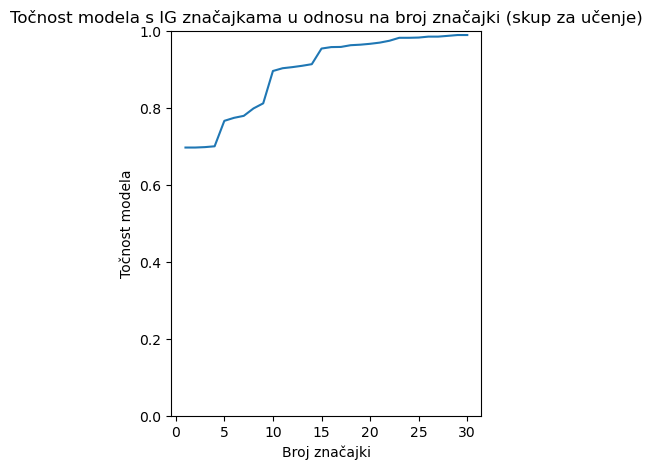

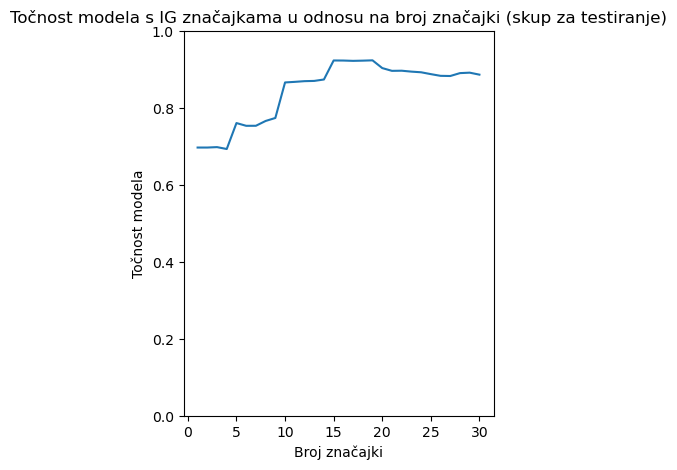

In [120]:
accuracies = np.zeros((2, 30))
precisions = np.zeros((2, 30))
recalls = np.zeros((2, 30))
f1_scores = np.zeros((2, 30))

parameters = {"C" : range(0, 200 + 1, 20), "gamma": [1.0]}

clf = GridSearchCV(estimator=SVC(), param_grid=parameters, n_jobs=-1)
clf.fit(X, Y)
svm_wf = clf.best_estimator_

eval_results = evaluate_ml_model(svm_wf, X, Y)
results_without_fs_train.loc["SVM", "accuracy"] = eval_results["train_accuracy"].mean()
results_without_fs_test.loc["SVM", "accuracy"] = eval_results["test_accuracy"].mean()
results_without_fs_train.loc["SVM", "precision"] = eval_results["train_precision"].mean()
results_without_fs_test.loc["SVM", "precision"] = eval_results["test_precision"].mean()
results_without_fs_train.loc["SVM", "recall"] = eval_results["train_recall"].mean()
results_without_fs_test.loc["SVM", "recall"] = eval_results["test_recall"].mean()
results_without_fs_train.loc["SVM", "f1"] = eval_results["train_f1"].mean()
results_without_fs_test.loc["SVM", "f1"] = eval_results["test_f1"].mean()


clf.fit(X_wrapper_features, Y)
svm_wrapper_features = clf.best_estimator_
eval_results = evaluate_ml_model(svm_wrapper_features, X_wrapper_features, Y)

results_wrapper_train.loc["SVM", "accuracy"] = eval_results["train_accuracy"].mean()
results_wrapper_test.loc["SVM", "accuracy"] = eval_results["test_accuracy"].mean()
results_wrapper_train.loc["SVM", "precision"] = eval_results["train_precision"].mean()
results_wrapper_test.loc["SVM", "precision"] = eval_results["test_precision"].mean()
results_wrapper_train.loc["SVM", "recall"] = eval_results["train_recall"].mean()
results_wrapper_test.loc["SVM", "recall"] = eval_results["test_recall"].mean()
results_wrapper_train.loc["SVM", "f1"] = eval_results["train_f1"].mean()
results_wrapper_test.loc["SVM", "f1"] = eval_results["test_f1"].mean()


clf.fit(X_pca, Y)
svm_pca = clf.best_estimator_    
eval_results = evaluate_ml_model(svm_pca, X_pca, Y)

results_pca_train.loc["SVM", "accuracy"] = eval_results["train_accuracy"].mean()
results_pca_test.loc["SVM", "accuracy"] = eval_results["test_accuracy"].mean()
results_pca_train.loc["SVM", "precision"] = eval_results["train_precision"].mean()
results_pca_test.loc["SVM", "precision"] = eval_results["test_precision"].mean()
results_pca_train.loc["SVM", "recall"] = eval_results["train_recall"].mean()
results_pca_test.loc["SVM", "recall"] = eval_results["test_recall"].mean()
results_pca_train.loc["SVM", "f1"] = eval_results["train_f1"].mean()
results_pca_test.loc["SVM", "f1"] = eval_results["test_f1"].mean()

for n_components in range(1, 30 + 1):
    X_ig = get_ig_features(X, Y, n_components)
    clf.fit(X_ig, Y)
    svm_ig = clf.best_estimator_

    eval_results = evaluate_ml_model(svm_ig, X_ig, Y)
    accuracies[0, n_components-1] = eval_results["train_accuracy"].mean()
    precisions[0, n_components-1] = eval_results["train_precision"].mean()
    recalls[0, n_components-1] = eval_results["train_recall"].mean()
    f1_scores[0, n_components-1] = eval_results["train_f1"].mean()

    accuracies[1, n_components-1] = eval_results["test_accuracy"].mean()
    precisions[1, n_components-1] = eval_results["test_precision"].mean()
    recalls[1, n_components-1] = eval_results["test_recall"].mean()
    f1_scores[1, n_components-1] = eval_results["test_f1"].mean()



results_ig_train.loc["SVM", "accuracy"] = np.max(accuracies, axis=1)[0]
results_ig_test.loc["SVM", "accuracy"] = np.max(accuracies, axis=1)[1]
results_ig_train.loc["SVM", "precision"] = np.max(precisions, axis=1)[0]
results_ig_test.loc["SVM", "precision"] = np.max(precisions, axis=1)[1]
results_ig_train.loc["SVM", "recall"] = np.max(recalls, axis=1)[0]
results_ig_test.loc["SVM", "recall"] = np.max(recalls, axis=1)[1]
results_ig_train.loc["SVM", "f1"] = np.max(f1_scores, axis=1)[0]
results_ig_test.loc["SVM", "f1"] = np.max(f1_scores, axis=1)[1]

plt.title("Točnost modela s IG značajkama u odnosu na broj značajki (skup za učenje)")
plt.plot(range(1,30 + 1), accuracies[0,:], scaley=[0, 1])
plt.xlabel("Broj značajki")
plt.ylabel("Točnost modela")
plt.ylim(top=1, bottom=0)
plt.show()

plt.title("Točnost modela s IG značajkama u odnosu na broj značajki (skup za testiranje)")
plt.plot(range(1,30 + 1), accuracies[1,:], scaley=[0, 1])
plt.xlabel("Broj značajki")
plt.ylabel("Točnost modela")
plt.ylim(top=1, bottom=0)
plt.show()

## Evaluacija stabla odluke

Stablo odluke je model koji se sastoji od stablaste strukture u kojoj su korijen i čvorovi stabla imena značajki, grane koje povezuju čvorove predstavljaju vrijednosti roditeljskog čvora i listovi predstavljaju oznake podataka. Klasifikacija nekog podatka se vrši spuštanjem niz stablo. Značajke podatka formiraju put do listova stabla. Ciljna oznaka u listu do kojeg dovodi put predstavlja razred u koji se klasificira podatak.

Hiperparametar stabla odluke koji se ugađa je dubina stabla. 
Stabla odluke koja nemaju ograničenu dubinu su sklona prenačenosti dok su stabla sa prestrogo zadanom dubinom stabla skloni podnaučenosti. 
Stoga je potrebno pažljivo odabrati najveću dozvoljenu dubinu stabla. 
Raspon dubine stabla koji će se provjeravati je od 1 do 30

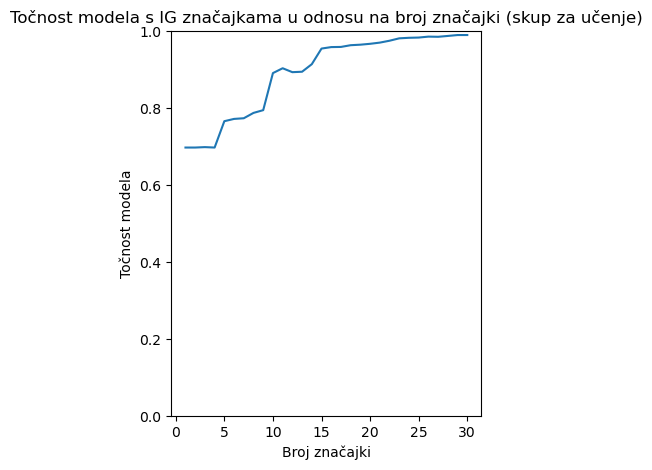

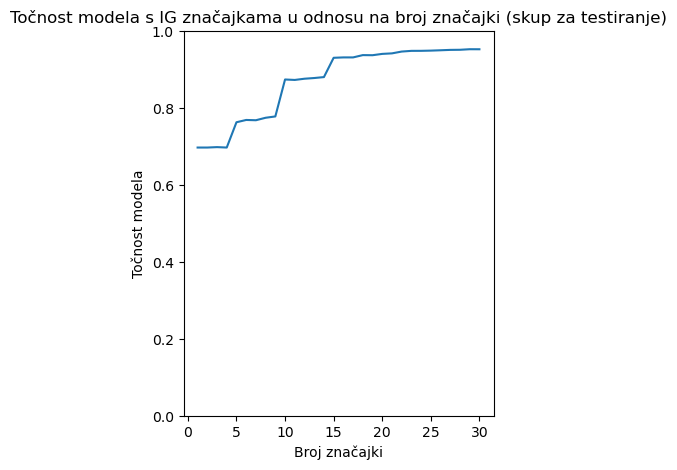

In [112]:
accuracies = np.zeros((2, 30))
precisions = np.zeros((2, 30))
recalls = np.zeros((2, 30))
f1_scores = np.zeros((2, 30))

parameters = {"max_depth" : range(1, 30 + 1)}

clf = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=parameters, n_jobs=-1)
clf.fit(X, Y)
dtc_wf = clf.best_estimator_

eval_results = evaluate_ml_model(dtc_wf, X, Y)
results_without_fs_train.loc["Stablo odluke", "accuracy"] = eval_results["train_accuracy"].mean()
results_without_fs_test.loc ["Stablo odluke", "accuracy"] = eval_results["test_accuracy"].mean()
results_without_fs_train.loc["Stablo odluke", "precision"] = eval_results["train_precision"].mean()
results_without_fs_test.loc ["Stablo odluke", "precision"] = eval_results["test_precision"].mean()
results_without_fs_train.loc["Stablo odluke", "recall"] = eval_results["train_recall"].mean()
results_without_fs_test.loc ["Stablo odluke", "recall"] = eval_results["test_recall"].mean()
results_without_fs_train.loc["Stablo odluke", "f1"] = eval_results["train_f1"].mean()
results_without_fs_test.loc ["Stablo odluke", "f1"] = eval_results["test_f1"].mean()


clf.fit(X_wrapper_features, Y)
dtc_wrapper_features = clf.best_estimator_
eval_results = evaluate_ml_model(dtc_wrapper_features, X_wrapper_features, Y)

results_wrapper_train.loc["Stablo odluke", "accuracy"] = eval_results["train_accuracy"].mean()
results_wrapper_test.loc ["Stablo odluke", "accuracy"] = eval_results["test_accuracy"].mean()
results_wrapper_train.loc["Stablo odluke", "precision"] = eval_results["train_precision"].mean()
results_wrapper_test.loc ["Stablo odluke", "precision"] = eval_results["test_precision"].mean()
results_wrapper_train.loc["Stablo odluke", "recall"] = eval_results["train_recall"].mean()
results_wrapper_test.loc ["Stablo odluke", "recall"] = eval_results["test_recall"].mean()
results_wrapper_train.loc["Stablo odluke", "f1"] = eval_results["train_f1"].mean()
results_wrapper_test.loc ["Stablo odluke", "f1"] = eval_results["test_f1"].mean()

clf.fit(X_pca, Y)
dtc_pca = clf.best_estimator_
eval_results = evaluate_ml_model(dtc_pca, X_pca, Y)

results_pca_train.loc["Stablo odluke", "accuracy"] = eval_results["train_accuracy"].mean()
results_pca_test.loc ["Stablo odluke", "accuracy"] = eval_results["test_accuracy"].mean()
results_pca_train.loc["Stablo odluke", "precision"] = eval_results["train_precision"].mean()
results_pca_test.loc ["Stablo odluke", "precision"] = eval_results["test_precision"].mean()
results_pca_train.loc["Stablo odluke", "recall"] = eval_results["train_recall"].mean()
results_pca_test.loc ["Stablo odluke", "recall"] = eval_results["test_recall"].mean()
results_pca_train.loc["Stablo odluke", "f1"] = eval_results["train_f1"].mean()
results_pca_test.loc ["Stablo odluke", "f1"] = eval_results["test_f1"].mean()


for n_components in range(1, 30 + 1):
    X_ig = get_ig_features(X, Y, n_components)
    clf.fit(X_ig, Y)
    dtc_ig = clf.best_estimator_

    eval_results = evaluate_ml_model(dtc_ig, X_ig, Y)
    accuracies[0, n_components-1] = eval_results["train_accuracy"].mean()
    precisions[0, n_components-1] = eval_results["train_precision"].mean()
    recalls[0, n_components-1] = eval_results["train_recall"].mean()
    f1_scores[0, n_components-1] = eval_results["train_f1"].mean()

    accuracies[1, n_components-1] = eval_results["test_accuracy"].mean()
    precisions[1, n_components-1] = eval_results["test_precision"].mean()
    recalls[1, n_components-1] = eval_results["test_recall"].mean()
    f1_scores[1, n_components-1] = eval_results["test_f1"].mean()

results_ig_train.loc["Stablo odluke", "accuracy"] = np.max(accuracies, axis=1)[0]
results_ig_test.loc ["Stablo odluke", "accuracy"] = np.max(accuracies, axis=1)[1]
results_ig_train.loc["Stablo odluke", "precision"] = np.max(precisions, axis=1)[0]
results_ig_test.loc ["Stablo odluke", "precision"] = np.max(precisions, axis=1)[1]
results_ig_train.loc["Stablo odluke", "recall"] = np.max(recalls, axis=1)[0]
results_ig_test.loc ["Stablo odluke", "recall"] = np.max(recalls, axis=1)[1]
results_ig_train.loc["Stablo odluke", "f1"] = np.max(f1_scores, axis=1)[0]
results_ig_test.loc ["Stablo odluke", "f1"] = np.max(f1_scores, axis=1)[1]

plt.title("Točnost modela s IG značajkama u odnosu na broj značajki (skup za učenje)")
plt.plot(range(1,30 + 1), accuracies[0,:], scaley=[0, 1])
plt.xlabel("Broj značajki")
plt.ylabel("Točnost modela")
plt.ylim(top=1, bottom=0)
plt.show()

plt.title("Točnost modela s IG značajkama u odnosu na broj značajki (skup za testiranje)")
plt.plot(range(1,30 + 1), accuracies[1,:], scaley=[0, 1])
plt.xlabel("Broj značajki")
plt.ylabel("Točnost modela")
plt.ylim(top=1, bottom=0)
plt.show()


## Evaluacija Random Forest klasifikatora

Random Forest klasifikator je model koji se sastoji od više stabla odluke pri čemu se svako stablo odluke uči na različitom podskupu podataka iz podataka za učenje. Prilikom klasifikacije podatka podatak klasficiraju sva stabla odluke te na izlazu daju oznaku razreda. Dobiveni izlazi se onda koriste za odlučivanje koji je konačni izlaz cijelog modela metodom glasanja, odnosno podatak se klasificira u razred koji većina stabla odluke daje na izlazu. 

Hiperparametri koji će se ugađati za random forest stabla odluke su maksimalna dubina stabala kao i kod običnih stabala odluke te broj procjenitelja koji predstavlja broj stabala odluke.

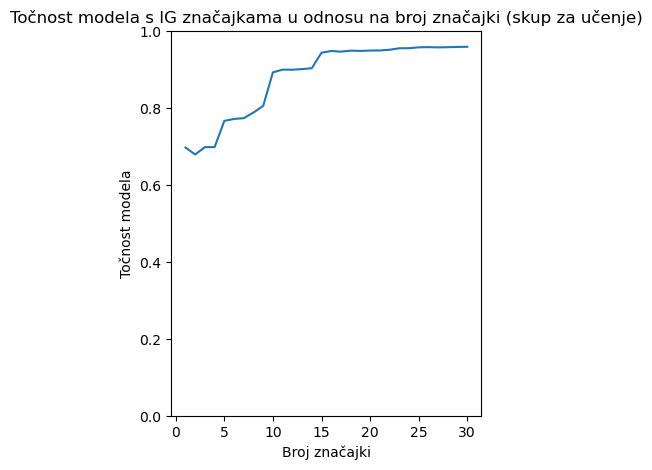

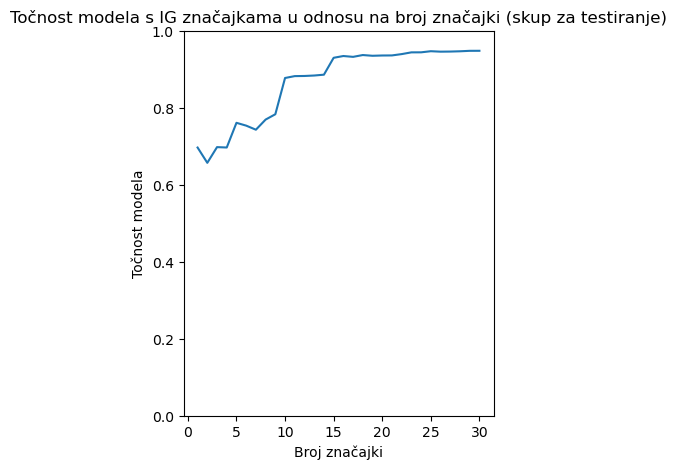

In [115]:
accuracies = np.zeros((2, 30))
precisions = np.zeros((2, 30))
recalls = np.zeros((2, 30))
f1_scores = np.zeros((2, 30))

parameters = {"max_depth" : range(1, 11), "n_estimators": range(10, 100 + 1, 10)}

clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameters, n_jobs=-1)
clf.fit(X, Y)
rfc_wf = clf.best_estimator_

eval_results = evaluate_ml_model(rfc_wf, X, Y)
results_without_fs_train.loc["Random Forest stabla odluke", "accuracy"] = eval_results["train_accuracy"].mean()
results_without_fs_test.loc ["Random Forest stabla odluke", "accuracy"] = eval_results["test_accuracy"].mean()
results_without_fs_train.loc["Random Forest stabla odluke", "precision"] = eval_results["train_precision"].mean()
results_without_fs_test.loc ["Random Forest stabla odluke", "precision"] = eval_results["test_precision"].mean()
results_without_fs_train.loc["Random Forest stabla odluke", "recall"] = eval_results["train_recall"].mean()
results_without_fs_test.loc ["Random Forest stabla odluke", "recall"] = eval_results["test_recall"].mean()
results_without_fs_train.loc["Random Forest stabla odluke", "f1"] = eval_results["train_f1"].mean()
results_without_fs_test.loc ["Random Forest stabla odluke", "f1"] = eval_results["test_f1"].mean()

clf.fit(X_wrapper_features, Y)
rfc_wrapper_features = clf.best_estimator_
eval_results = evaluate_ml_model(rfc_wrapper_features, X_wrapper_features, Y)

results_wrapper_train.loc["Random Forest stabla odluke", "accuracy"] = eval_results["train_accuracy"].mean()
results_wrapper_test.loc ["Random Forest stabla odluke", "accuracy"] = eval_results["test_accuracy"].mean()
results_wrapper_train.loc["Random Forest stabla odluke", "precision"] = eval_results["train_precision"].mean()
results_wrapper_test.loc ["Random Forest stabla odluke", "precision"] = eval_results["test_precision"].mean()
results_wrapper_train.loc["Random Forest stabla odluke", "recall"] = eval_results["train_recall"].mean()
results_wrapper_test.loc ["Random Forest stabla odluke", "recall"] = eval_results["test_recall"].mean()
results_wrapper_train.loc["Random Forest stabla odluke", "f1"] = eval_results["train_f1"].mean()
results_wrapper_test.loc ["Random Forest stabla odluke", "f1"] = eval_results["test_f1"].mean()

clf.fit(X_pca, Y)
rfc_pca = clf.best_estimator_
eval_results = evaluate_ml_model(rfc_pca, X_pca, Y)

results_pca_train.loc["Random Forest stabla odluke", "accuracy"] = eval_results["train_accuracy"].mean()
results_pca_test.loc ["Random Forest stabla odluke", "accuracy"] = eval_results["test_accuracy"].mean()
results_pca_train.loc["Random Forest stabla odluke", "precision"] = eval_results["train_precision"].mean()
results_pca_test.loc ["Random Forest stabla odluke", "precision"] = eval_results["test_precision"].mean()
results_pca_train.loc["Random Forest stabla odluke", "recall"] = eval_results["train_recall"].mean()
results_pca_test.loc ["Random Forest stabla odluke", "recall"] = eval_results["test_recall"].mean()
results_pca_train.loc["Random Forest stabla odluke", "f1"] = eval_results["train_f1"].mean()
results_pca_test.loc ["Random Forest stabla odluke", "f1"] = eval_results["test_f1"].mean()


for n_components in range(1, 30 + 1):
    X_ig = get_ig_features(X, Y, n_components)
    clf.fit(X_ig, Y)
    rfc_ig = clf.best_estimator_

    eval_results = evaluate_ml_model(rfc_ig, X_ig, Y)
    accuracies[0, n_components-1] = eval_results["train_accuracy"].mean()
    precisions[0, n_components-1] = eval_results["train_precision"].mean()
    recalls[0, n_components-1] = eval_results["train_recall"].mean()
    f1_scores[0, n_components-1] = eval_results["train_f1"].mean()

    accuracies[1, n_components-1] = eval_results["test_accuracy"].mean()
    precisions[1, n_components-1] = eval_results["test_precision"].mean()
    recalls[1, n_components-1] = eval_results["test_recall"].mean()
    f1_scores[1, n_components-1] = eval_results["test_f1"].mean()

results_ig_train.loc["Random Forest stabla odluke", "accuracy"] = np.max(accuracies, axis=1)[0]
results_ig_test.loc ["Random Forest stabla odluke", "accuracy"] = np.max(accuracies, axis=1)[1]
results_ig_train.loc["Random Forest stabla odluke", "precision"] = np.max(precisions, axis=1)[0]
results_ig_test.loc ["Random Forest stabla odluke", "precision"] = np.max(precisions, axis=1)[1]
results_ig_train.loc["Random Forest stabla odluke", "recall"] = np.max(recalls, axis=1)[0]
results_ig_test.loc ["Random Forest stabla odluke", "recall"] = np.max(recalls, axis=1)[1]
results_ig_train.loc["Random Forest stabla odluke", "f1"] = np.max(f1_scores, axis=1)[0]
results_ig_test.loc ["Random Forest stabla odluke", "f1"] = np.max(f1_scores, axis=1)[1]

plt.title("Točnost modela s IG značajkama u odnosu na broj značajki (skup za učenje)")
plt.plot(range(1,30 + 1), accuracies[0,:], scaley=[0, 1])
plt.xlabel("Broj značajki")
plt.ylabel("Točnost modela")
plt.ylim(top=1, bottom=0)
plt.show()

plt.title("Točnost modela s IG značajkama u odnosu na broj značajki (skup za testiranje)")
plt.plot(range(1,30 + 1), accuracies[1,:], scaley=[0, 1])
plt.xlabel("Broj značajki")
plt.ylabel("Točnost modela")
plt.ylim(top=1, bottom=0)
plt.show()

## Evaluacija višeslojnog perceptrona

Višeslojni perceptron je mreža neurona. U mreži razlikujemo ulazni sloj, skriveni sloj i izlazni sloj. 
U ulaznom sloju neuroni samo propuštaju podatak do neurona u skrivenom sloju. 

Skriveni slojevi rade linearna preslikavanja prethodnih neurona.
Na izlazu svakog neurona (osim ulaznih) nalazi se nelinerana aktivacijska funkcija koja preslikava izlaz neurona.
Dobiveni izlazi se prosljeđuju sljedećem skrivenom sloju neurona ili na izlazni sloj neurona.

Izlazni sloj neuronske mreže daje razred u koji klasificira podatak na ulazu.

Hiperparametar koji će se ugađati kod višeslojnog perceptrona je broj neurona u skrivenim slojevima te broj skrivenih slojeva. Dodatno će se vrednovati točnost modela koji koristi $ReLU$ kao aktivacijsku funkciju te model koji koristi funkciju sigmoide kao aktivacijsku funkciju.

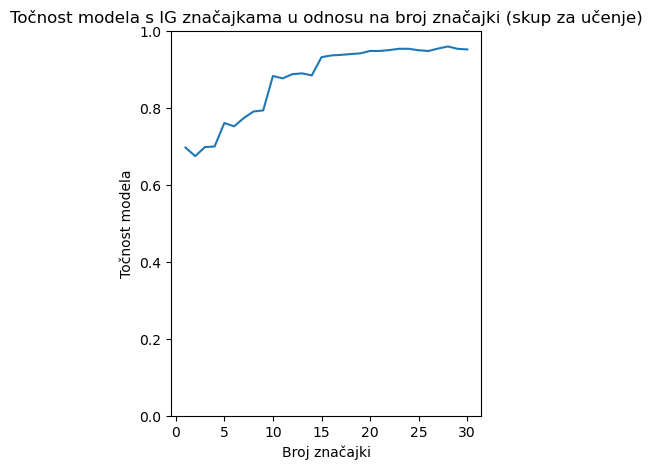

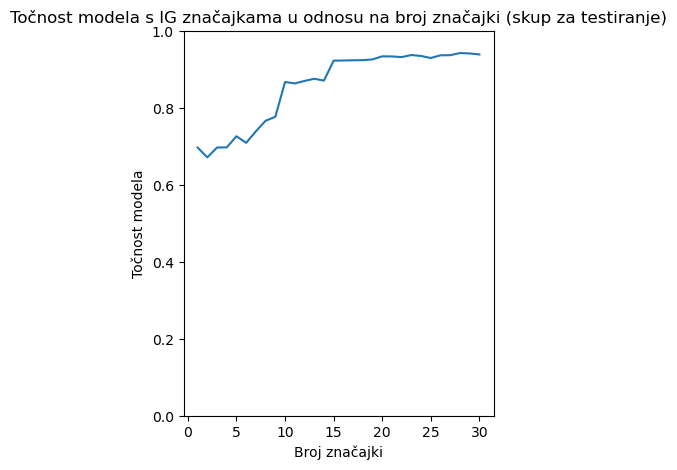

In [119]:
accuracies = np.zeros((2, 30))
precisions = np.zeros((2, 30))
recalls = np.zeros((2, 30))
f1_scores = np.zeros((2, 30))

parameters = {"hidden_layer_sizes" : [(5), (10), (5, 5), (10, 10), (5, 5, 5)], "activation": ["relu", "logistic"]}

clf = GridSearchCV(estimator=MLPClassifier(learning_rate="adaptive"), param_grid=parameters, n_jobs=-1)
clf.fit(X, Y)
mlp_wf = clf.best_estimator_

eval_results = evaluate_ml_model(mlp_wf, X, Y)
results_without_fs_train.loc["Višeslojni perceptron", "accuracy"] = eval_results["train_accuracy"].mean()
results_without_fs_test.loc ["Višeslojni perceptron", "accuracy"] = eval_results["test_accuracy"].mean()
results_without_fs_train.loc["Višeslojni perceptron", "precision"] = eval_results["train_precision"].mean()
results_without_fs_test.loc ["Višeslojni perceptron", "precision"] = eval_results["test_precision"].mean()
results_without_fs_train.loc["Višeslojni perceptron", "recall"] = eval_results["train_recall"].mean()
results_without_fs_test.loc ["Višeslojni perceptron", "recall"] = eval_results["test_recall"].mean()
results_without_fs_train.loc["Višeslojni perceptron", "f1"] = eval_results["train_f1"].mean()
results_without_fs_test.loc ["Višeslojni perceptron", "f1"] = eval_results["test_f1"].mean()


clf.fit(X_wrapper_features, Y)
mlp_wrapper_features = clf.best_estimator_
eval_results = evaluate_ml_model(mlp_wrapper_features, X_wrapper_features, Y)

results_wrapper_train.loc["Višeslojni perceptron", "accuracy"] = eval_results["train_accuracy"].mean()
results_wrapper_test.loc ["Višeslojni perceptron", "accuracy"] = eval_results["test_accuracy"].mean()
results_wrapper_train.loc["Višeslojni perceptron", "precision"] = eval_results["train_precision"].mean()
results_wrapper_test.loc ["Višeslojni perceptron", "precision"] = eval_results["test_precision"].mean()
results_wrapper_train.loc["Višeslojni perceptron", "recall"] = eval_results["train_recall"].mean()
results_wrapper_test.loc ["Višeslojni perceptron", "recall"] = eval_results["test_recall"].mean()
results_wrapper_train.loc["Višeslojni perceptron", "f1"] = eval_results["train_f1"].mean()
results_wrapper_test.loc ["Višeslojni perceptron", "f1"] = eval_results["test_f1"].mean()


clf.fit(X_pca, Y)
mlp_pca = clf.best_estimator_
eval_results = evaluate_ml_model(mlp_pca, X_pca, Y)

results_pca_train.loc["Višeslojni perceptron", "accuracy"] = eval_results["train_accuracy"].mean()
results_pca_test.loc ["Višeslojni perceptron", "accuracy"] = eval_results["test_accuracy"].mean()
results_pca_train.loc["Višeslojni perceptron", "precision"] = eval_results["train_precision"].mean()
results_pca_test.loc ["Višeslojni perceptron", "precision"] = eval_results["test_precision"].mean()
results_pca_train.loc["Višeslojni perceptron", "recall"] = eval_results["train_recall"].mean()
results_pca_test.loc ["Višeslojni perceptron", "recall"] = eval_results["test_recall"].mean()
results_pca_train.loc["Višeslojni perceptron", "f1"] = eval_results["train_f1"].mean()
results_pca_test.loc ["Višeslojni perceptron", "f1"] = eval_results["test_f1"].mean()

for n_components in range(1, 30 + 1):
    X_ig = get_ig_features(X, Y, n_components)
    clf.fit(X_ig, Y)
    mlp_ig = clf.best_estimator_

    eval_results = evaluate_ml_model(mlp_ig, X_ig, Y)
    accuracies[0, n_components-1] = eval_results["train_accuracy"].mean()
    precisions[0, n_components-1] = eval_results["train_precision"].mean()
    recalls[0, n_components-1] = eval_results["train_recall"].mean()
    f1_scores[0, n_components-1] = eval_results["train_f1"].mean()

    accuracies[1, n_components-1] = eval_results["test_accuracy"].mean()
    precisions[1, n_components-1] = eval_results["test_precision"].mean()
    recalls[1, n_components-1] = eval_results["test_recall"].mean()
    f1_scores[1, n_components-1] = eval_results["test_f1"].mean()

results_ig_train.loc["Višeslojni perceptron", "accuracy"] = np.max(accuracies, axis=1)[0]
results_ig_test.loc ["Višeslojni perceptron", "accuracy"] = np.max(accuracies, axis=1)[1]
results_ig_train.loc["Višeslojni perceptron", "precision"] = np.max(precisions, axis=1)[0]
results_ig_test.loc ["Višeslojni perceptron", "precision"] = np.max(precisions, axis=1)[1]
results_ig_train.loc["Višeslojni perceptron", "recall"] = np.max(recalls, axis=1)[0]
results_ig_test.loc ["Višeslojni perceptron", "recall"] = np.max(recalls, axis=1)[1]
results_ig_train.loc["Višeslojni perceptron", "f1"] = np.max(f1_scores, axis=1)[0]
results_ig_test.loc ["Višeslojni perceptron", "f1"] = np.max(f1_scores, axis=1)[1]

plt.title("Točnost modela s IG značajkama u odnosu na broj značajki (skup za učenje)")
plt.plot(range(1,30 + 1), accuracies[0,:], scaley=[0, 1])
plt.xlabel("Broj značajki")
plt.ylabel("Točnost modela")
plt.ylim(top=1, bottom=0)
plt.show()

plt.title("Točnost modela s IG značajkama u odnosu na broj značajki (skup za testiranje)")
plt.plot(range(1,30 + 1), accuracies[1,:], scaley=[0, 1])
plt.xlabel("Broj značajki")
plt.ylabel("Točnost modela")
plt.ylim(top=1, bottom=0)
plt.show()

# Prikaz rezultata

U sljedećem dijelu su prikazane točnosti, preciznosti, odziv i f1-vrijednost za sve modele.

Broj ispravno klasificiranih pozitivnih primjera označava se s $TP$, broj lažno pozitivno klasificiranih primjera označava se s $FP$, broj ispravno klasificiranih negativnih primjera označava se s $TN$ i broj neispravno klasificiranih negativnih primjera označava se s $FN$.

Točnost se definira kao omjer broja ispravno klasificiranih podataka i ukupnog broja podataka, odnosno $ Acc = \frac{TP + TN}{TP+FP+TN+FN}.$

Preciznost se definira kao omjer broja ispravno klasificiranih pozitivnih primjera i broja pozitivnih detekcija, odnosno $P = \frac{TP}{TP + FP}$

Odziv se definira kao omjer broja ispravno klasificiranih pozitivnih primjera i broja pozitivnih primjera, odnosno $R = \frac{TP}{TP + FN}$

F1 mjera se definira kao geometrijska sredina preciznosti i odziva te je njena formula $F1 = \sqrt{P * R}$.

Navedene metrike su primjenjene nad modelima koji su na ulazu imali značajke dobivene postupcima omotača, za modele koji su koristili značajke dobivene analizom glavnih komponenti te nad modelima koji su koristili značajke s najvećom informacijskom dobiti.

Mjerenja nad modelima su bila provedena na skupu za učenje i na skupu za testiranje.

In [122]:
print("Train data")

rwfs_styler = results_without_fs_train.style.set_table_attributes("style='display:inline'").set_caption('All features')
rw_styler = results_wrapper_train.style.set_table_attributes("style='display:inline'").set_caption('Wrapper features')
rpca_t_styler = results_pca_train.style.set_table_attributes("style='display:inline'").set_caption('PCA components')
rig_t_styler = results_ig_train.style.set_table_attributes("style='display:inline'").set_caption('Features with highest information gain')

space = "\xa0" * 10

display_html(rwfs_styler._repr_html_() + space + 
             rw_styler._repr_html_() + space +
             rpca_t_styler._repr_html_() + space + 
             rig_t_styler._repr_html_(), raw=True)

print()
print()
print("Test data")


rwfs_styler = results_without_fs_test.style.set_table_attributes("style='display:inline'").set_caption('All features')
rw_styler = results_wrapper_test.style.set_table_attributes("style='display:inline'").set_caption('Wrapper features')
rpca_t_styler = results_pca_test.style.set_table_attributes("style='display:inline'").set_caption('PCA components')
rig_t_styler = results_ig_test.style.set_table_attributes("style='display:inline'").set_caption('Features with highest information gain')

space = "\xa0" * 10

display_html(rwfs_styler._repr_html_() + space + 
             rw_styler._repr_html_() + space +
             rpca_t_styler._repr_html_() + space + 
             rig_t_styler._repr_html_(), raw=True)

Train data


,accuracy,precision,recall,f1
Naivni Bayesov klasifikator,0.907372,0.917794,0.915706,0.916749
k-NN,0.988422,0.990165,0.989037,0.989599
SVM,0.990118,0.987978,0.994356,0.991157
Stablo odluke,0.989937,0.991345,0.990580,0.990962
Random Forest stabla odluke,0.960516,0.951823,0.978642,0.965046
Višeslojni perceptron,0.961375,0.959006,0.972227,0.965566
,accuracy,precision,recall,f1
Naivni Bayesov klasifikator,0.909928,0.917811,0.920740,0.919265
k-NN,0.978765,0.980644,0.981241,0.980942
SVM,0.983695,0.981358,0.989524,0.985424




Test data


,accuracy,precision,recall,f1
Naivni Bayesov klasifikator,0.902397,0.909973,0.915541,0.912682
k-NN,0.949525,0.949156,0.961191,0.955100
SVM,0.887200,0.851526,0.975480,0.907911
Stablo odluke,0.953777,0.957329,0.959569,0.958420
Random Forest stabla odluke,0.948530,0.937644,0.972389,0.954667
Višeslojni perceptron,0.940208,0.936820,0.957287,0.946920
,accuracy,precision,recall,f1
Naivni Bayesov klasifikator,0.904659,0.908729,0.921554,0.915023
k-NN,0.949525,0.947682,0.962649,0.955068
SVM,0.900226,0.866803,0.974991,0.916900


# Zaključak

Modeli za detekciju phishing web stranica koji se temelje na odabiru značajki postupcima omotača daju visoku preciznost za testnim skupovima. 
Iz tog razloga se pokazuju kao dobar alat za detekciju i uklanjanje phishing web stranica.

Modeli koji na ulazu primaju značajke dobivene postupcima omotača daju veću točnost na skupu za testiranje od modela koji na ulazima primaju sve značajke, dok na skupu za treniranje vrijedi obrnuto. Iz navedenoga se može zaključiti da modeli koji na ulazima primaju značajke dobivene postupcima omotača imaju bolje svojstvo generalizacije.

Razlike u mjerenjima u odnosu na izvorni rad javljaju se zbog stohastične prirode učenja modela. Dodatno se razlike javljaju zbog nedovoljne definiranosti modela korištenih u izvornom radu, odnosno rad specificira samo vrste modela koji su bili korišteni za izgradnju detektora phishing stranica. Rad ne specificira korištene hiperparametre modela kao ni arhitekturu modela višeslojnog perceptrona što predstavlja važnu informaciju prilikom učenja modela. Hiperparametri uvelike utječu na preciznost modela te je njihov pažljiv odabir važan za ostvarivanje visoke preciznosti.